In [34]:
import numpy as np
from torch import nn
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from typing import Tuple
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [35]:
n = 10000
df = pd.DataFrame(
    {
        "feature1": np.random.uniform(-100,100,size = n),
    }    
)
df["feature1_first_derivative"]= df["feature1"].diff(1).fillna(0)
df["feature1_second_derivative"]= df["feature1_first_derivative"].diff(1).fillna(0)
df["feature2"]= np.random.uniform(-100,100,size = n)
df["random"] = np.random.uniform(-100,100,size = n)
df["target"] = 2*df["feature1"] + df["feature2"]  + 5
df

,feature1,feature1_first_derivative,feature1_second_derivative,feature2,random,target
0,19.497619,0.000000,0.000000,70.995478,19.690813,114.990716
1,71.728897,52.231278,52.231278,26.063476,-63.834117,174.521270
2,-50.120254,-121.849152,-174.080430,-66.705961,84.099804,-161.946470
3,4.729937,54.850191,176.699343,41.774995,-99.807387,56.234868
4,-84.551115,-89.281051,-144.131242,-13.296770,49.340304,-177.399000
...,...,...,...,...,...,...
9995,45.842355,52.521157,61.721208,60.629720,19.852443,157.314429
9996,-73.166820,-119.009174,-171.530332,51.918832,94.620464,-89.414807
9997,95.562374,168.729193,287.738367,-96.779922,-99.720211,99.344825
9998,17.619997,-77.942377,-246.671570,-18.217959,30.787713,22.022035


In [36]:
scaler = StandardScaler().set_output(transform = "pandas")
df = scaler.fit_transform(df)
df

,feature1,feature1_first_derivative,feature1_second_derivative,feature2,random,target
0,0.334716,-0.000068,-0.000041,1.228480,0.337799,0.845972
1,1.240000,0.646378,0.374344,0.445022,-1.108244,1.307670
2,-0.871916,-1.508147,-1.247818,-1.172553,1.452893,-1.301859
3,0.078759,0.678792,1.266509,0.718976,-1.731039,0.390281
4,-1.468679,-1.105064,-1.033148,-0.241283,0.851112,-1.421703
...,...,...,...,...,...,...
9995,0.791329,0.649966,0.442366,1.047737,0.340597,1.174220
9996,-1.271364,-1.472998,-1.229540,0.895850,1.635034,-0.739328
9997,1.653087,2.088227,2.062417,-1.696938,-1.729530,0.724628
9998,0.302173,-0.964730,-1.768139,-0.327092,0.529916,0.124938


In [49]:
class CnnModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn1 = nn.Conv1d(
            in_channels = 2,
            out_channels = 10,
            kernel_size = 5,
            padding = "same",
        )
        self.pool1 = nn.MaxPool1d(
            kernel_size = 2,
            padding = 0,
            ceil_mode = True,
        )
        self.cnn2 = nn.Conv1d(
            in_channels = 10,
            out_channels = 10,
            kernel_size = 5,
            padding = "same",
        )
        self.pool2 = nn.MaxPool1d(
            kernel_size = 2,
            padding = 0,
            ceil_mode = True,
        )
        self.fc1 = nn.Linear(8, 1)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_cnn1 = self.cnn1(x)
        y_cnn1 = self.activation(y_cnn1)
        y_pool1 = self.pool1(y_cnn1)

        return y_pool1
       
class CnnDataset(Dataset):
    def __init__(
            self, 
            X_lstm: torch.Tensor,
            y_lstm: torch.Tensor,
    ) -> None:
        self.X_lstm = X_lstm
        self.y_lstm = y_lstm

    def __len__(
            self,
    ) -> int:
        return self.X_lstm.shape[0]
        
    def __getitem__(
            self, 
            index
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        X = self.X_lstm[index,:,:]

        y = self.y_lstm[index]
        return X,y

In [38]:
L = 100
X_list = []
y_list = []
for i in range(df.shape[0]-L+1):
    X_list.append(
        df.iloc[i:i+L,:-1].loc[:,["feature1", "feature2"]],
    )
    y_list.append(
        df.iloc[i+L-1,-1],
    )
X_lstm = torch.Tensor(np.array(X_list)).float()
y_lstm = torch.Tensor(np.array(y_list)).float()

In [45]:
ingang = X_lstm.permute(0,2,1)
ingang

tensor([[[ 0.3347,  1.2400, -0.8719,  ..., -0.6245, -1.0609,  0.4599],
         [ 1.2285,  0.4450, -1.1726,  ...,  0.1826,  0.4303, -1.2451]],

        [[ 1.2400, -0.8719,  0.0788,  ..., -1.0609,  0.4599,  0.7277],
         [ 0.4450, -1.1726,  0.7190,  ...,  0.4303, -1.2451,  0.2667]],

        [[-0.8719,  0.0788, -1.4687,  ...,  0.4599,  0.7277,  0.0557],
         [-1.1726,  0.7190, -0.2413,  ..., -1.2451,  0.2667,  0.8131]],

        ...,

        [[-0.4309,  0.0046,  0.1071,  ...,  0.7913, -1.2714,  1.6531],
         [ 1.6345, -1.6955,  0.4369,  ...,  1.0477,  0.8958, -1.6969]],

        [[ 0.0046,  0.1071,  0.9469,  ..., -1.2714,  1.6531,  0.3022],
         [-1.6955,  0.4369, -1.0452,  ...,  0.8958, -1.6969, -0.3271]],

        [[ 0.1071,  0.9469,  1.5385,  ...,  1.6531,  0.3022,  1.2835],
         [ 0.4369, -1.0452,  0.1169,  ..., -1.6969, -0.3271, -1.6102]]])

In [50]:
model = CnnModel()
uitgang = model(ingang)
uitgang

tensor([[[0.0000, 0.0072, 0.4833,  ..., 0.1975, 0.0000, 0.5986],
         [0.3926, 1.1260, 0.0000,  ..., 0.0000, 0.6689, 0.6458],
         [0.6353, 0.2794, 0.4285,  ..., 0.5190, 0.7446, 0.6230],
         ...,
         [0.0219, 0.1036, 0.2190,  ..., 0.0259, 0.1032, 0.0000],
         [0.3313, 0.4080, 0.2649,  ..., 0.8691, 0.2673, 0.4204],
         [0.1293, 0.8678, 0.1618,  ..., 0.3965, 0.7912, 0.0000]],

        [[0.0000, 0.4833, 0.4654,  ..., 0.1975, 0.6399, 0.0000],
         [0.0000, 1.1260, 0.6385,  ..., 0.0000, 0.7909, 0.5005],
         [0.4333, 0.4285, 0.9747,  ..., 0.7446, 0.3913, 0.4345],
         ...,
         [0.0000, 0.1036, 0.8288,  ..., 0.1032, 0.0000, 0.1437],
         [0.4139, 0.4080, 0.0000,  ..., 0.8691, 0.2922, 0.2178],
         [0.8667, 0.1618, 0.1861,  ..., 0.7912, 0.1609, 0.0000]],

        [[0.4628, 0.4833, 0.4654,  ..., 0.0000, 0.6399, 0.3221],
         [1.4921, 0.0000, 0.6385,  ..., 0.6689, 0.7909, 0.6496],
         [0.3086, 0.4285, 0.9747,  ..., 0.7446, 0.3913, 0.

In [51]:
uitgang.shape

torch.Size([9901, 10, 50])

In [41]:
lstm_epochs = 10
lstm_plt_dict = {
    "x": [],
    "y": [],
}
lstm_dataset = LstmDataset(
    X_lstm=X_lstm,
    y_lstm=y_lstm,
)

lstm_dataloader = DataLoader(
    lstm_dataset,
    batch_size=10,
    shuffle=True,
)

lstm_model = LstmModel()
lstm_criterion = torch.nn.MSELoss()

lstm_optimizer = Adam(
    params = lstm_model.parameters(),
    lr = 1/1000,
    weight_decay=1e-5,

)
for epoch in range(lstm_epochs):
    for i,(lstm_X, lstm_y_true) in enumerate(lstm_dataloader):
        lstm_optimizer.zero_grad()
        lstm_y_pred = lstm_model(lstm_X)
        lstm_loss = lstm_criterion(
            lstm_y_pred,
            lstm_y_true,
        )
        lstm_loss.backward()
        lstm_optimizer.step()
        if i % 100 == 0:
            print(lstm_loss)
        lstm_plt_dict["x"].append(i*(epoch+1))
        lstm_plt_dict["y"].append(lstm_loss.item())
        
    print(f"Epoch {epoch} done.")

AttributeError: 'LstmModel' object has no attribute 'lstm'

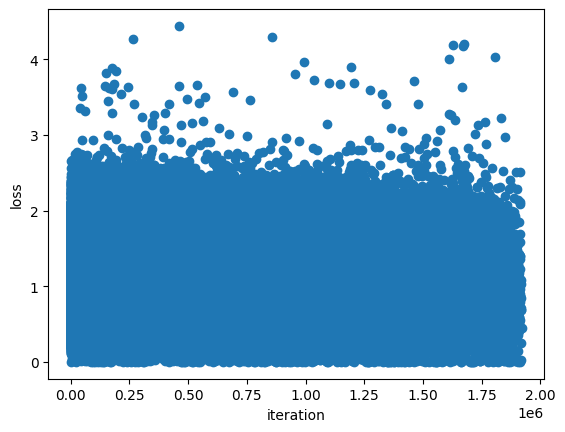

In [14]:
lstm_fig, lstm_ax = plt.subplots()
lstm_ax.scatter(lstm_plt_dict["x"],lstm_plt_dict["y"])
lstm_ax.set_xlabel("iteration")
lstm_ax.set_ylabel("loss")
lstm_fig.show()


In [26]:
def count_trainable_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_trainable_parameters(lstm_model)

393

In [27]:
torch.Tensor().numel()

0